### 第一题

使用决策树预测糖尿病。

#### 题目

##### Context


This dataset is originally from the National Institute of Diabetes and Digestive and Kidney
Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

##### Content

The datasets consists of several medical predictor variables and one target variable, Outcome.
Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin
level, age, and so on

#### 解答

##### 导入数据

In [1]:
import pandas as pd

col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
pima = pd.read_csv("hw4-pima-indians-diabetes.csv", header=None, names=col_names)
pima.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


##### 选择预测所需的特征


In [2]:
# 选择预测所需的特征
feature_cols = ['pregnant', 'insulin', 'bmi', 'age','glucose','bp','pedigree']
X = pima[feature_cols] # 特征
y = pima.label # 类别标签

##### 将数据分为训练和测试数据

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=2023)

##### 创建决策树分类器

In [4]:
from sklearn.tree import DecisionTreeClassifier
clf=DecisionTreeClassifier() #默认使用CART算法，若用ID3 criterion="entropy"

##### 训练模型

In [5]:
clf.fit(X_train,y_train)

DecisionTreeClassifier()

##### 使用训练好的模型做预测

In [6]:
y_predict=clf.predict(X_test)

##### 模型的准确性

In [7]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_predict))

Accuracy: 0.7360594795539034


##### 可视化训练好的决策数模型

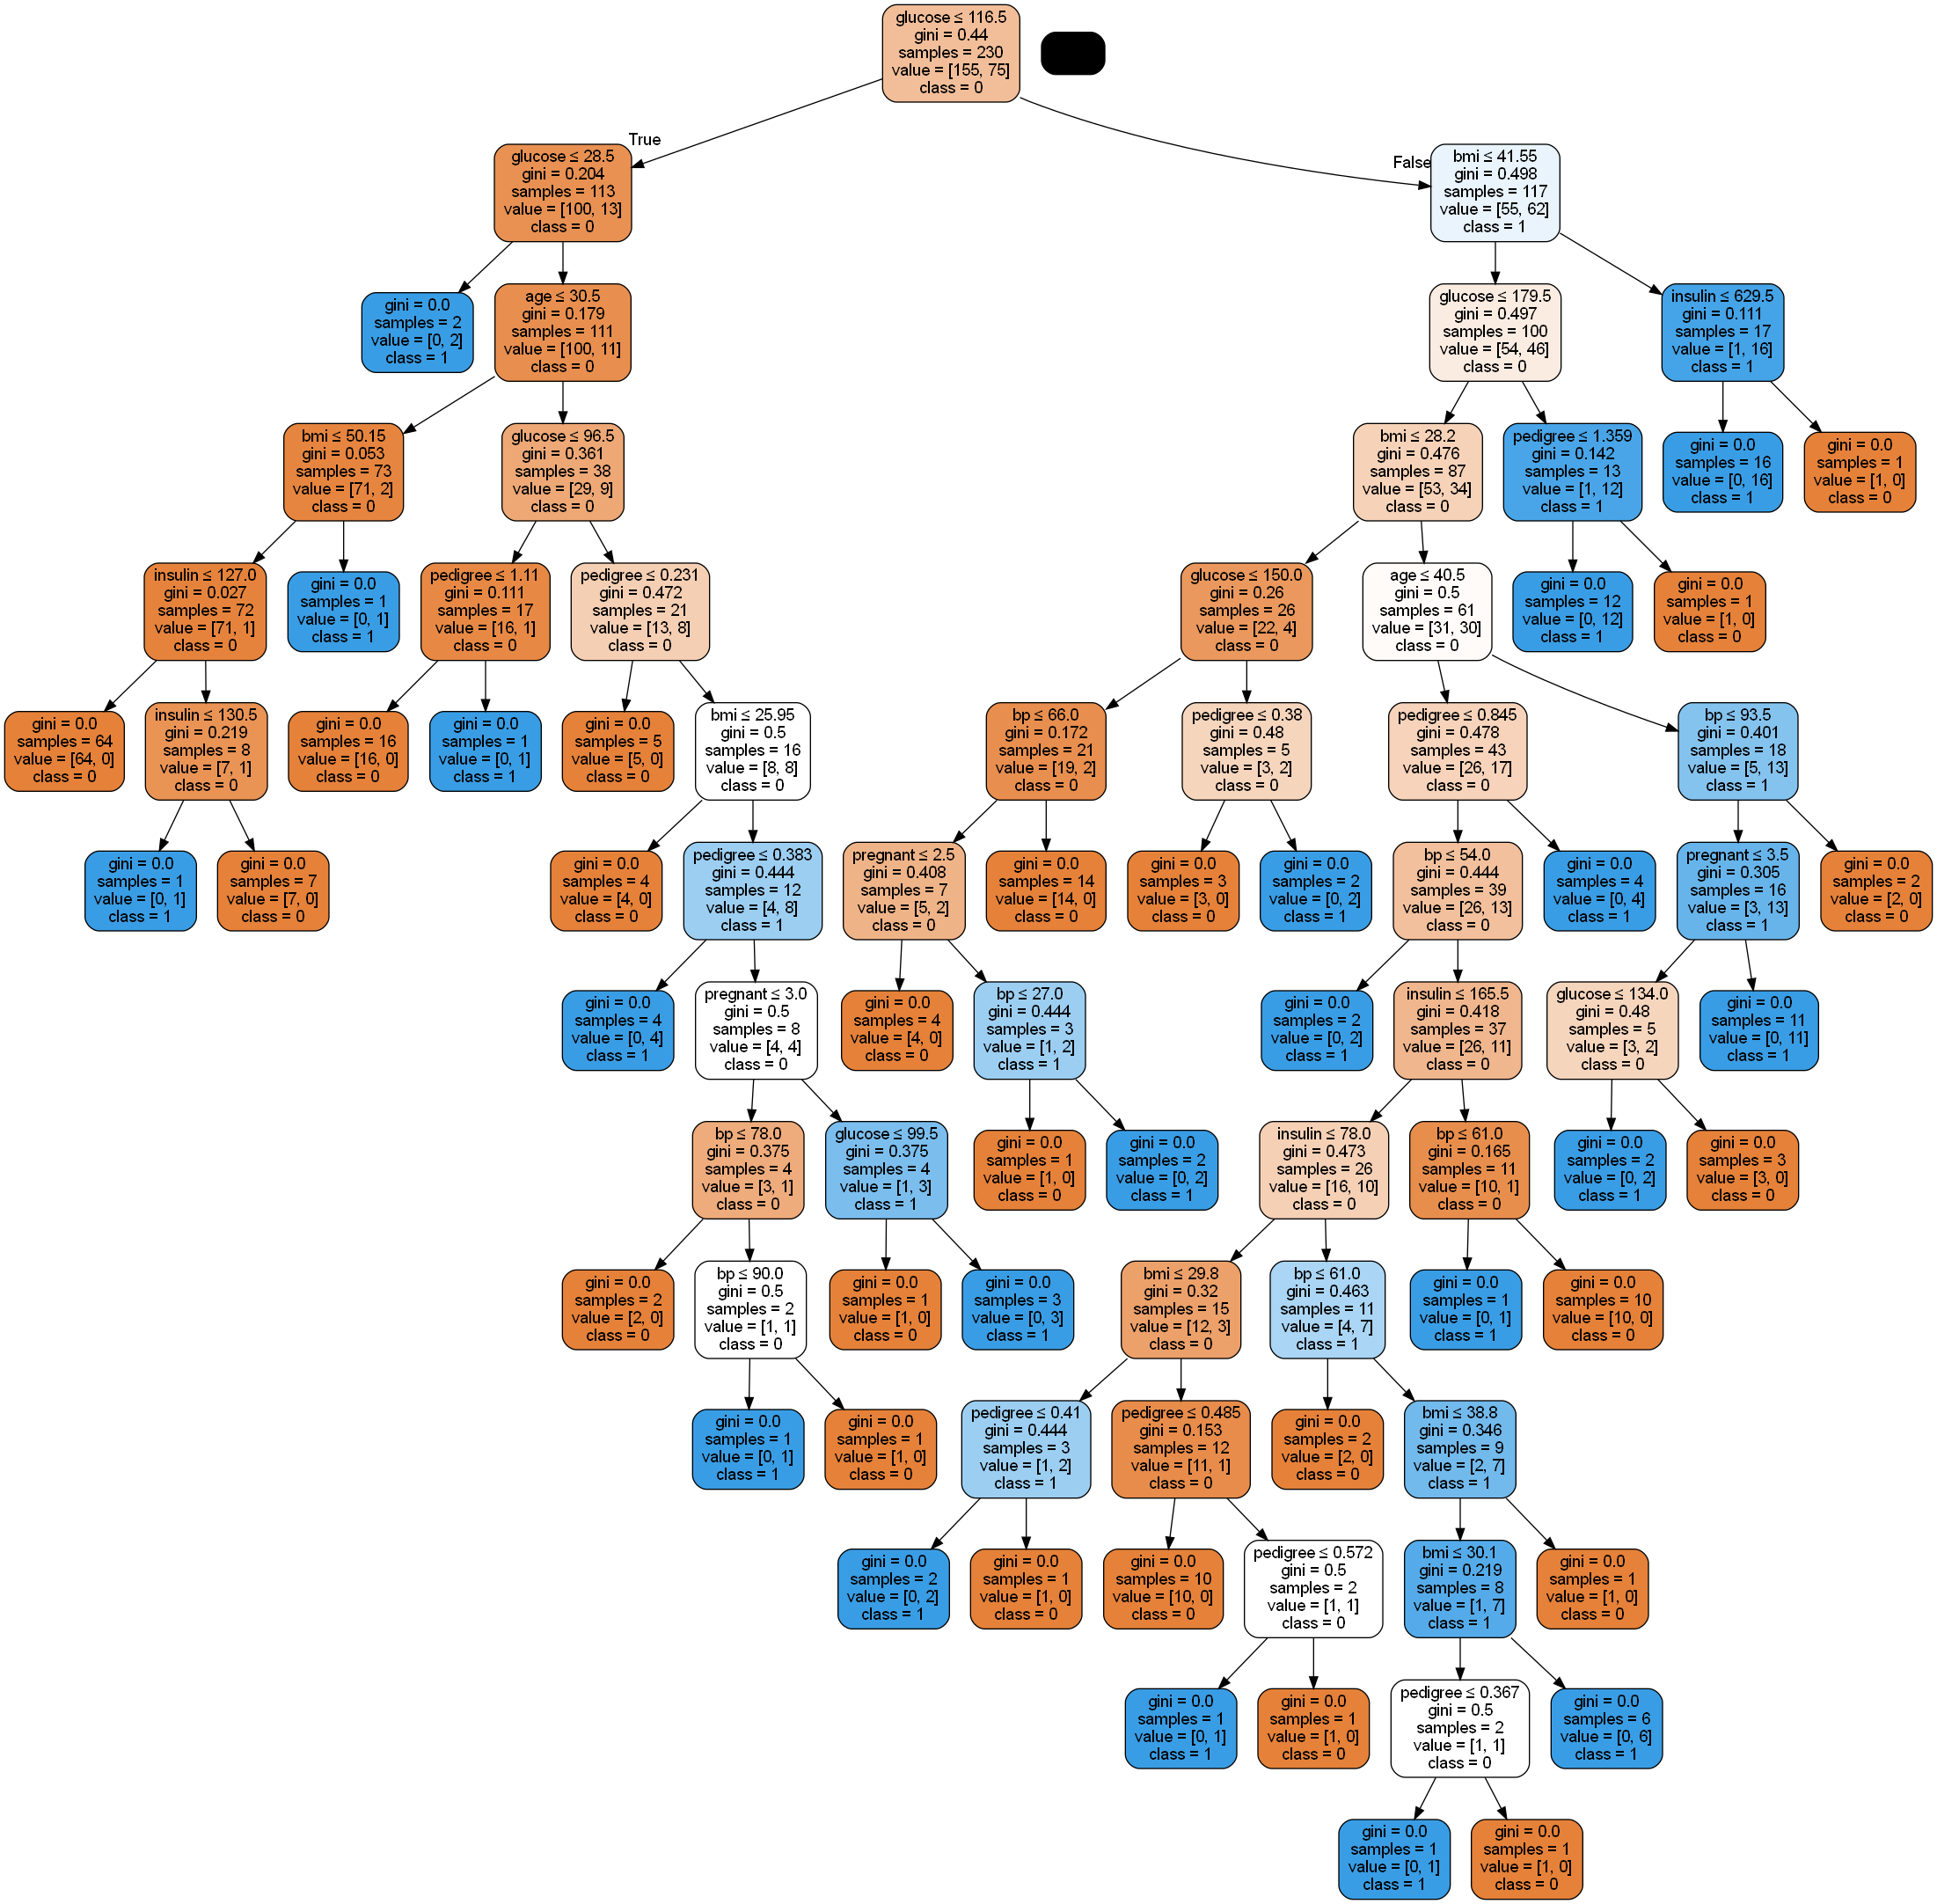

In [8]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,filled=True, rounded=True,special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('./diabetes_1.png')
Image(graph.create_png())

##### 创建新的决策树, 限定最大深度为6

In [9]:
clf = DecisionTreeClassifier(max_depth = 6)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7360594795539034


##### 可视化新的决策树

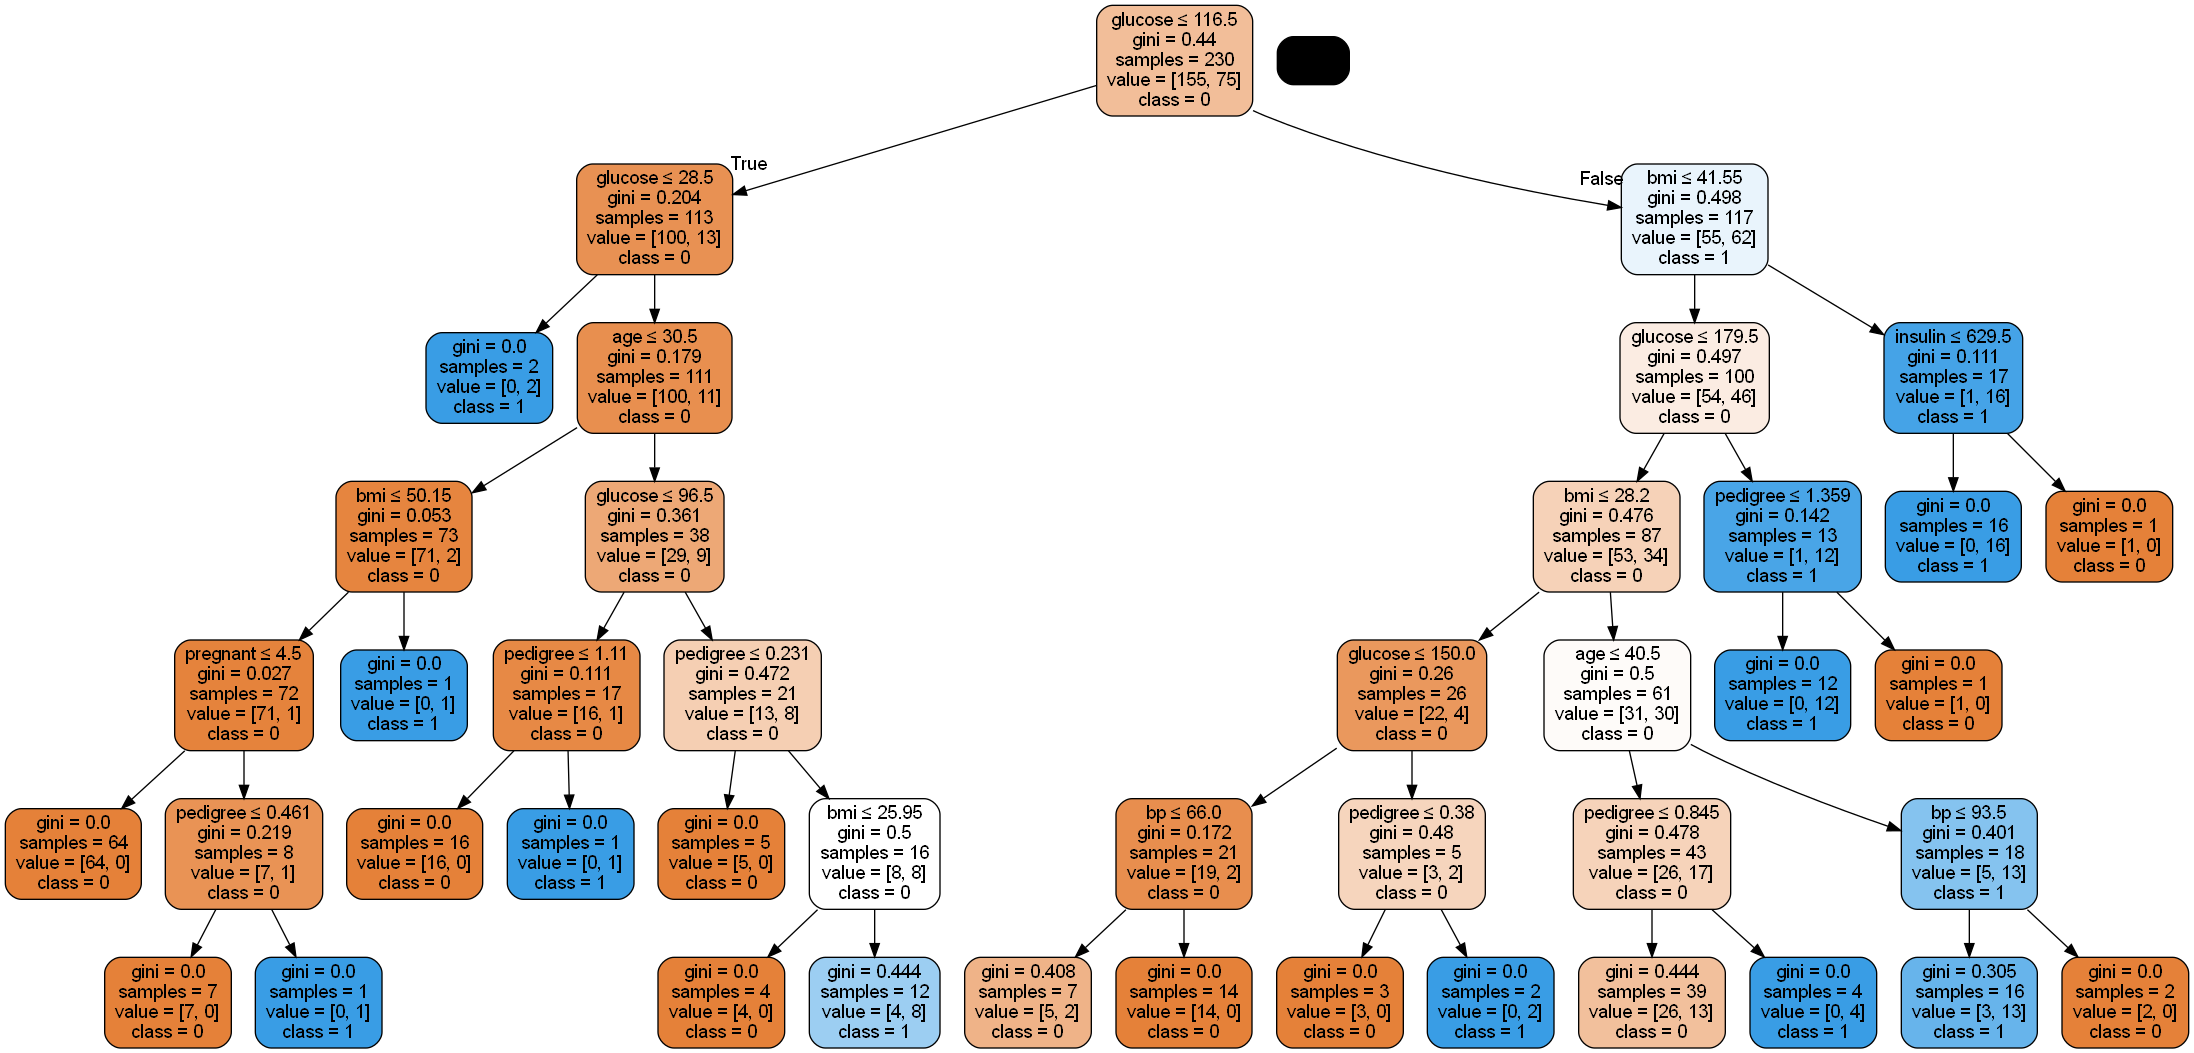

In [10]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,filled=True, rounded=True,special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('./diabetes_2.png')
Image(graph.create_png())

### 第二题

对地图上的点进行聚类

#### 题目


现在有一个存有中国许多城市及其经纬度的文本，而没有这些地点的距离信息。而我们想要对这些地点进行聚类。显然，K-means算法可以为我们找到一种更加经济而且高效的出行方式。

通过地址信息获取相应的经纬度信息

那么，既然没有地点之间的距离信息，怎么计算地点之间的距离呢？又如何比较地点之间的远近呢？

#### 解答


##### 加载数据

In [11]:
import pandas as pd
from numpy import *

def loadData(path):
    dataframe=pd.read_csv(path)
    dataframe.head()
    print("\n")
    datList=[]
    #代码中坐标默认为（东经，北纬）形式
    #与数据文件中相反，因此读取文件的时候注意调换位置
    datList=dataframe.iloc[:,[3,2]]
    return mat(datList)

datMat=loadData("China_cities.csv")
#print(datMat)

##### 通过经纬度计算距离的方法：

球面上两点 $A(λ_1, φ_1)$、$B(λ_2, φ_2)$，$λ$ 和 $φ$ 分别表示它们在地图中的经度、纬度；

$θ$ 为 $弧AB$ 对应的圆心角，则有球面余弦定理：

$θ=arccos(cosφ_1cosφ_2cos(λ_2−λ_1) + sinφ_1sinφ_2)$

则AB弧长=$\theta \times 地球平均半径(6371km)$

In [12]:

# 利用球面余弦定理计算球面距离
def distSLC(vecA, vecB):
    '''
    参数：两点经纬度；
    返回值：两点间球面距离
    '''
    # 返回地球表面两点之间的距离
    return arccos(cos(vecA[0,1]*pi/180) * cos(vecB[0,1]*pi/180) * cos(pi * (vecB[0,0]-vecA[0,0]) /180) + sin(vecA[0,1]*pi/180) * sin(vecB[0,1]*pi/180))*6371.0 


def distEclud(vecA, vecB):
    '''
    （本问题并没有用到该函数，但由于欧式距离是默认的距离计算函数，所以保留此函数）
    参数：两点坐标；
    返回值：两点间欧式距离
    
    '''
    return sqrt(sum(power(vecA - vecB, 2))) #la.norm(vecA-vecB)

##### 生成随机质心

In [13]:

def randCent(dataSet, k):
    '''
    randCent() 为给定数据集构建一个包含k 个随机质心的集合。
    随机质心必须要在整个数据集的边界之内，这可以通过找到数据集每一维的最小和最大值来完成。然后生成0 到1.0 之间的随机数并通过取值范围和最小值，以便确保随机点在数据的边界之内。
    '''
    n = shape(dataSet)[1]# n:坐标的维数，本问题中n=2

    centroids = mat(zeros((k,n)))#k行n列的矩阵，存放了k个坐标
    for j in range(n):#create random cluster centers, within bounds of each dimension
        minJ = min(dataSet[:,j])#找出第j个坐标维度上的最小值
        rangeJ = float(max(dataSet[:,j]) - minJ)#找出第j个坐标维度上的极差值
        centroids[:,j] = mat(minJ + rangeJ * random.rand(k,1))
    return centroids



##### k-mean聚类

In [14]:
def kMeans(dataSet, k, distMeas=distEclud, createCent=randCent):
    '''
    kMeans() 函数一开始确定数据集中数据点的总数，然后创建一个矩阵clusterAssment来存储每个点的簇分配结果。
    簇分配结果矩阵clusterAssment 包含两列：一列记录簇索引值，第二列存储误差。这里的误差是指当前点到簇质心的距离。

    '''
    m = shape(dataSet)[0]#m为dataSet的行数，即坐标点的数量
    clusterAssment = mat(zeros((m,2)))#create mat to assign data points
                #to a centroid, also holds SE of each point
    centroids = createCent(dataSet, k)#初始化质心(此处为随机初始化质心)

    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m):#遍历所有坐标点

            minDist = inf; minIndex = -1
            for j in range(k): #遍历所有质心，找出最短距离和对应的最近质心Index
                distJI = distMeas(centroids[j,:],dataSet[i,:])
                if distJI < minDist:
                    minDist = distJI; minIndex = j

            if clusterAssment[i,0] != minIndex: #如果发现在此次迭代后，存在某点，其最近质心发生了
                clusterChanged = True           #变化，则说明还没收敛，要继续迭代

            clusterAssment[i,:] = minIndex,minDist**2 #更新坐标点的最近质心，注意此处的minDist平方！
        #print(centroids)
        for cent in range(k):#遍历质心
            ptsInClust = dataSet[nonzero(clusterAssment[:,0].A==cent)[0]]#找到所有以该质心为最近质心的坐标点
            centroids[cent,:] = mean(ptsInClust, axis=0) #将该质心更新为聚类点的均值坐标
    return centroids, clusterAssment


```
clusterAssment[i,:] = minIndex,minDist**2
```

上面返回的结果中，之所以存储每个数据点距离其质心误差距离平方，是便于后续的算法预处理。

因为K-means 算法采取的是随机初始化k 个簇的质心的方式，因此聚类效果又可能陷入局部最优解的情况，局部最优解虽然效果不错，但不如全局最优解的聚类效果更好。

所以，后续会在算法结束后，采取相应的后处理，使算法跳出局部最优解，达到全局最优解，获得最好的聚类效果

##### 二分K-means


In [15]:
def biKmeans(dataSet, k, distMeas=distEclud):
    m = shape(dataSet)[0]#m：当前簇内的坐标点总数
    #print(f"m={m}")
    clusterAssment = mat(zeros((m,2)))
    centroid0 = mean(dataSet, axis=0).tolist()[0]
    centList =[centroid0] #初始化当前聚类结果：仅有一个簇，质心在所有点的均值坐标处

    for j in range(0,m): # 初始化误差距离
        clusterAssment[j,1] = distMeas(mat(centroid0), dataSet[j,:])**2

    while (len(centList) < k): # 每次循环在centList中增加一个质心
        lowestSSE = inf
        for i in range(len(centList)):
            ptsInCurrCluster = dataSet[nonzero(clusterAssment[:,0].A==i)[0],:]#get the data points currently in cluster i
            centroidMat, splitClustAss = kMeans(ptsInCurrCluster, 2, distMeas)
            sseSplit = sum(splitClustAss[:,1])
                #计算将当前聚类再划分后的距离和
            sseNotSplit = sum(clusterAssment[nonzero(clusterAssment[:,0].A!=i)[0],1])
                #计算非当前聚类的误差距离和
            #print("sseSplit, and notSplit: ",sseSplit,sseNotSplit)
            if (sseSplit + sseNotSplit) < lowestSSE:
                bestCentToSplit = i
                bestNewCents = centroidMat
                bestClustAss = splitClustAss.copy()
                lowestSSE = sseSplit + sseNotSplit
        bestClustAss[nonzero(bestClustAss[:,0].A == 1)[0],0] = len(centList) #change 1 to 3,4, or whatever
        bestClustAss[nonzero(bestClustAss[:,0].A == 0)[0],0] = bestCentToSplit
        #print ('the bestCentToSplit is: ',bestCentToSplit)
        #print ('the len of bestClustAss is: ', len(bestClustAss))
        centList[bestCentToSplit] = bestNewCents[0,:].tolist()[0]#replace a centroid with two best centroids
        centList.append(bestNewCents[1,:].tolist()[0])
        clusterAssment[nonzero(clusterAssment[:,0].A == bestCentToSplit)[0],:]= bestClustAss#reassign new clusters, and SSE

    return mat(centList), clusterAssment


##### 测试与可视化



质心为：
[[103.42517357  37.14564   ]
 [116.029457    27.80611295]
 [115.77828471  35.06380236]
 [102.29795621  28.2816919 ]
 [124.41748212  43.84615626]
 [ 83.96534857  42.98813929]
 [111.87840678  22.87858678]]


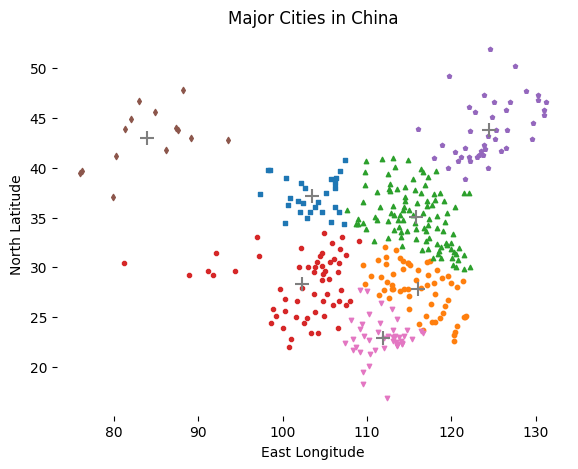

In [16]:

import matplotlib.pyplot as plt

def clusterClubs(numClust=5):
    
    datMat=loadData("China_cities.csv")

    myCentroids, clustAssing = biKmeans(datMat, numClust, distMeas=distSLC)

    fig = plt.figure()
    rect=[0.1,0.1,0.8,0.8]
    scatterMarkers=['s', 'o', '^', '8', 'p', 'd', 'v', 'h', '>', '<']

    ax1=fig.add_axes(rect, label='ax1', frameon=False)
    plt.title("Major Cities in China")
    plt.xlabel("East Longitude")
    plt.ylabel("North Latitude")
    for i in range(numClust):
        ptsInCurrCluster = datMat[nonzero(clustAssing[:,0].A==i)[0],:]
        markerStyle = scatterMarkers[i % len(scatterMarkers)]
        ax1.scatter(ptsInCurrCluster[:,0].flatten().A[0], ptsInCurrCluster[:,1].flatten().A[0],marker=markerStyle, s=10)

    ax1.scatter(myCentroids[:,0].flatten().A[0], myCentroids[:,1].flatten().A[0], marker='+', s=90)
    print("质心为：")
    print(myCentroids)
    plt.show()

clusterClubs(numClust=7)